In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
data_dir=  "/kaggle/input/cricket-shot-dataset/data/"

In [3]:
import pathlib

In [4]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/kaggle/input/cricket-shot-dataset/data')

In [5]:
image_count = len(list(data_dir.glob('*/*')))
image_count

4724

In [6]:
list(data_dir.glob('*/*'))[:5]

[PosixPath('/kaggle/input/cricket-shot-dataset/data/pullshot/pullshot143.png'),
 PosixPath('/kaggle/input/cricket-shot-dataset/data/pullshot/pullshot29.png'),
 PosixPath('/kaggle/input/cricket-shot-dataset/data/pullshot/pullshot726.png'),
 PosixPath('/kaggle/input/cricket-shot-dataset/data/pullshot/pullshot412.png'),
 PosixPath('/kaggle/input/cricket-shot-dataset/data/pullshot/pullshot1250.png')]

In [7]:
shot_img_dict = {
    'drive': list(data_dir.glob('drive/*')),
    'legglance-flick': list(data_dir.glob('legglance-flick/*')),
    'pullshot': list(data_dir.glob('pullshot/*')),
    'sweep': list(data_dir.glob('sweep/*'))
}

shot_label_dict = {
    'drive': 0,
    'legglance-flick': 1,
    'pullshot': 2,
    'sweep': 3
}

In [8]:
import cv2
img  = cv2.imread(str(shot_img_dict['drive'][0]))
img.shape


(194, 259, 3)

In [9]:
X, y = [], []

for shot, images in shot_img_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (180, 180))
        X.append(resized_img)
        y.append(shot_label_dict[shot])

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [13]:
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)


In [37]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
pre_trained_model = VGG19(input_shape=(180, 180, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False
model = Sequential([
    pre_trained_model,
    MaxPool2D((2, 2), strides=2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'), 
    Dropout(0.3),  
    Dense(4, activation='softmax')  #
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 5, 5, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,287,172 (77.39 MB)

 Trainable params: 4,982,404 (19.01 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [15]:
history = model.fit(X_train_scaled, y_train_cat, epochs=50, validation_data=(X_test_scaled, y_test_cat), batch_size=32)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 65s 440ms/step - accuracy: 0.3971 - loss: 1.3928 - val_accuracy: 0.8290 - val_loss: 0.4756
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.8225 - loss: 0.4801 - val_accuracy: 0.9365 - val_loss: 0.2017
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.9212 - loss: 0.2313 - val_accuracy: 0.9577 - val_loss: 0.1334
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9610 - loss: 0.1262 - val_accuracy: 0.9577 - val_loss: 0.1190
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.9769 - loss: 0.0709 - val_accuracy: 0.9763 - val_loss: 0.0791
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.9829 - loss: 0.0538 - val_accuracy: 0.9729 - val_loss: 0.0692
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.9922 - loss: 0.0320 - val_accuracy: 0.9763 - val_loss: 0.0627
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.9899 - loss: 0

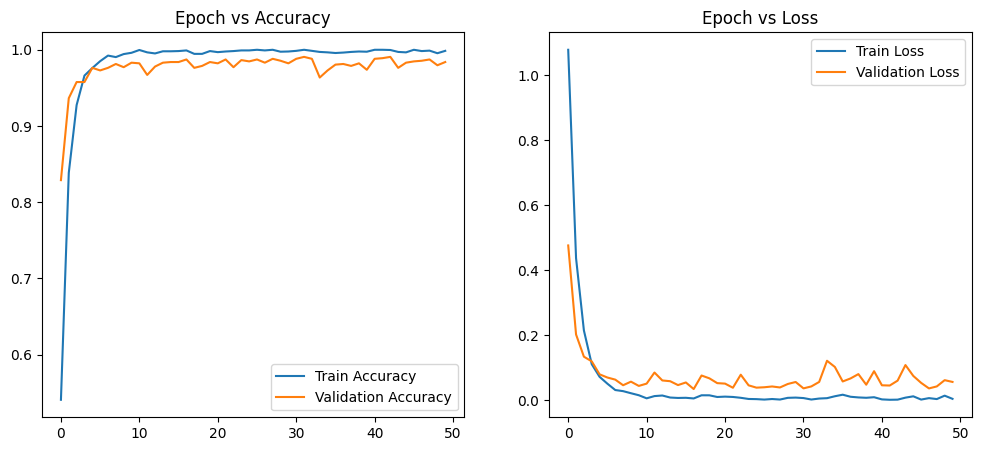

In [16]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Epoch vs Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Epoch vs Loss')
plt.show()

In [17]:
model.evaluate(X_test_scaled ,y_test_cat)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9830 - loss: 0.0561


[0.05568129941821098, 0.98391193151474]

In [18]:
pred = model.predict(X_test_scaled)
pred[:5]

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step


array([[1.0000000e+00, 4.1711284e-11, 1.8830626e-09, 1.1747903e-10],
       [7.3410562e-11, 1.2822554e-12, 1.0000000e+00, 2.7811189e-16],
       [6.1249854e-18, 2.6126036e-13, 4.4539504e-19, 1.0000000e+00],
       [1.5954207e-06, 1.0543528e-08, 9.9999845e-01, 3.7105909e-09],
       [1.0000000e+00, 2.5385244e-16, 4.3376568e-16, 5.4593636e-19]],
      dtype=float32)

In [19]:
pred = [np.argmax(i) for i in pred]


In [20]:
pred[:20]

[0, 2, 3, 2, 0, 0, 0, 3, 1, 2, 3, 1, 2, 3, 0, 2, 3, 2, 1, 1]

In [21]:
list(y_test[:20])

[0, 2, 3, 2, 0, 0, 0, 3, 1, 2, 3, 1, 2, 3, 0, 2, 3, 2, 1, 1]

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


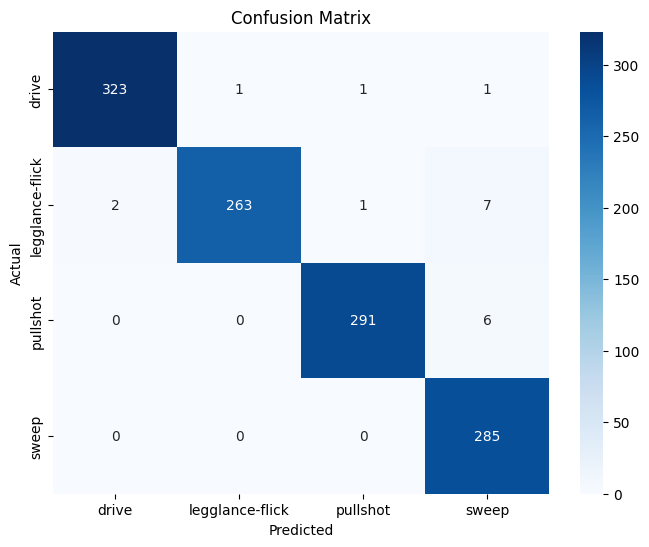

In [22]:
# Predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=shot_label_dict.keys(), yticklabels=shot_label_dict.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
# Classification Report
print(classification_report(y_test, y_pred, target_names=shot_label_dict.keys()))


                 precision    recall  f1-score   support

          drive       0.99      0.99      0.99       326
legglance-flick       1.00      0.96      0.98       273
       pullshot       0.99      0.98      0.99       297
          sweep       0.95      1.00      0.98       285

       accuracy                           0.98      1181
      macro avg       0.98      0.98      0.98      1181
   weighted avg       0.98      0.98      0.98      1181



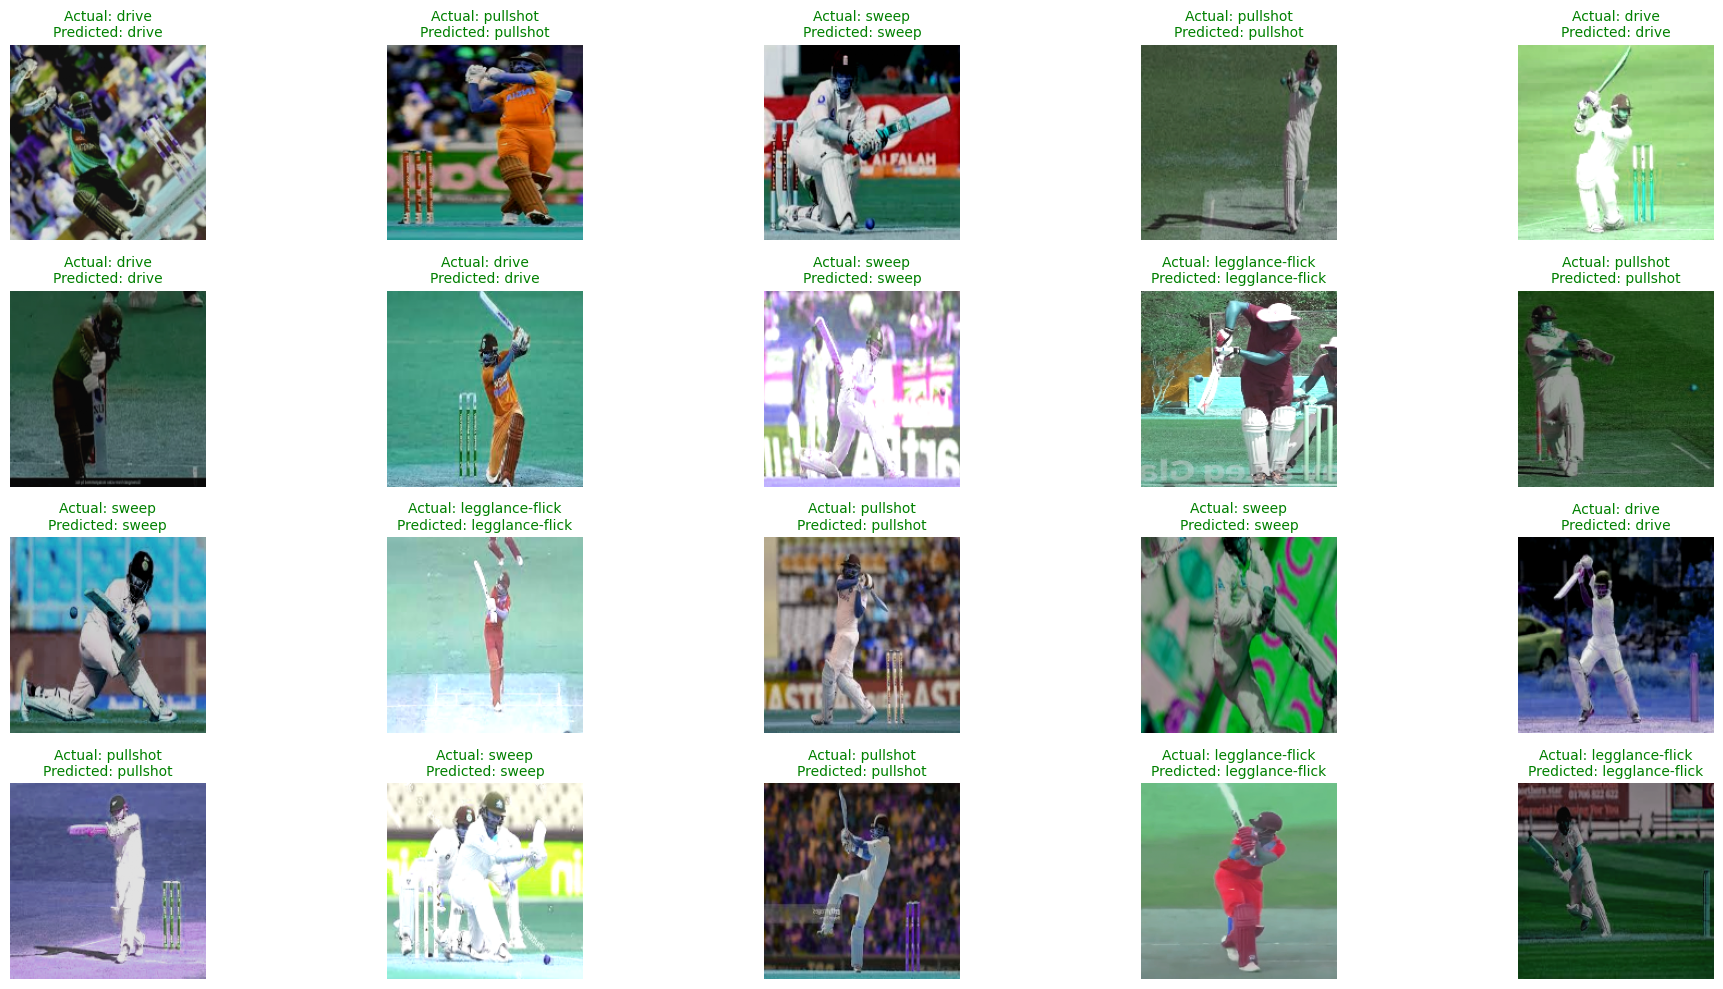

In [24]:
import matplotlib.pyplot as plt
import numpy as np

label_map = {0: 'drive', 1: 'legglance-flick', 2: 'pullshot', 3: 'sweep'}

num_images = 20

plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
    plt.imshow(X_test_scaled[i])  # Show the image
    actual_label = label_map[y_test[i]]
    predicted_label = label_map[pred[i]]
    
    # Set title with actual vs predicted labels
    title_color = 'green' if actual_label == predicted_label else 'red'
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=title_color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [26]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 12.5 MB/s eta 0:00:0000:010:01


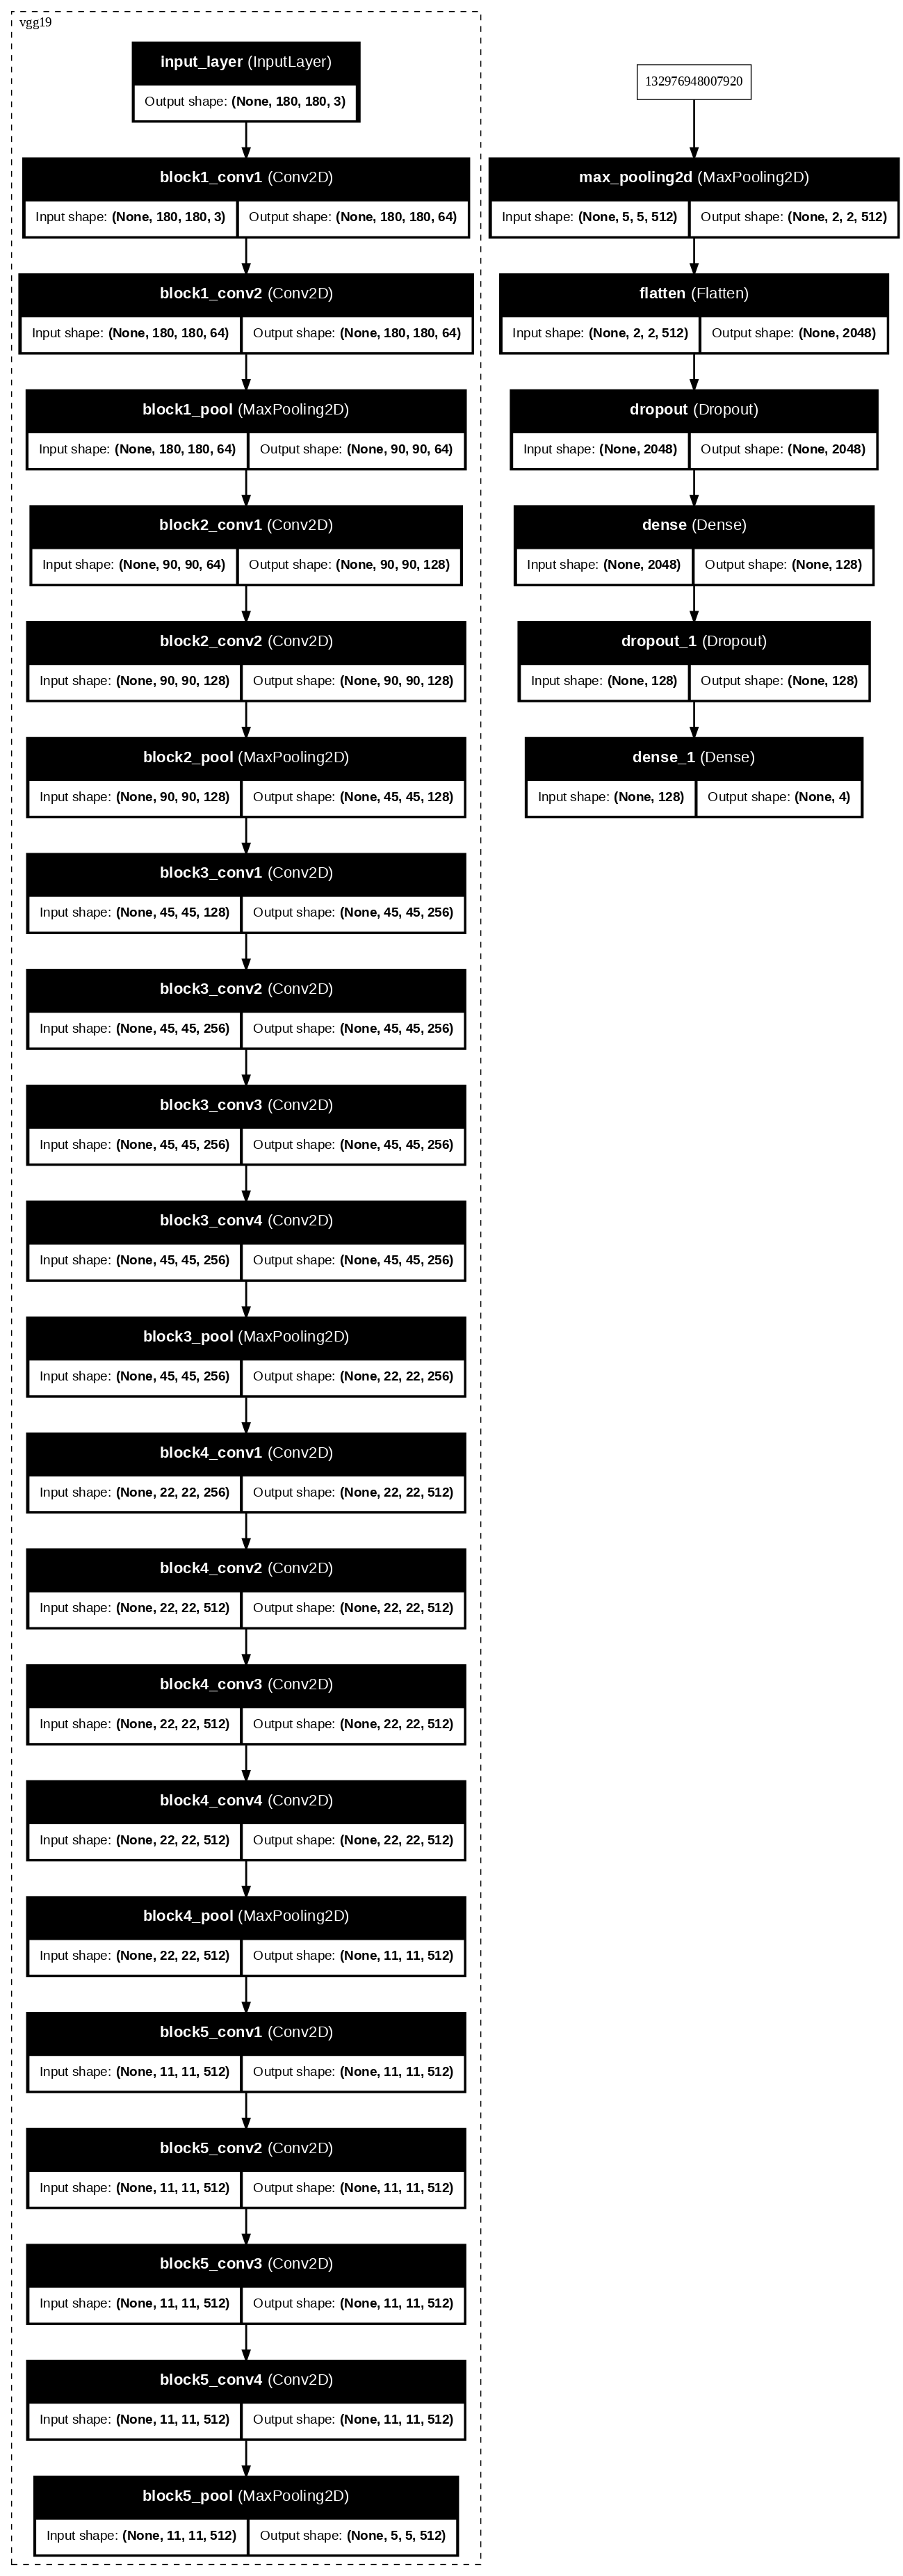

In [31]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Save the model architecture as an image
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True, expand_nested=True, dpi=100)

# Display the saved image
Image("model_plot.png")


In [32]:
model.save("my_model.h5")  # Saves the model in H5 format


In [39]:
# import visualkeras
# from PIL import ImageFont

# try:
#     font = ImageFont.truetype("arial.ttf", 50)  # Adjust size as needed
# except IOError:
#     font = None #i#ncrease font size (adjust as needed)

# # Generate the model visualization with larger legend text
# img = visualkeras.layered_view(model, legend=True, font=font)

# if img.mode == "RGBA":
#     img = img.convert("RGB")

# # Save the image
# img.save("vgg16_layers_large_legend.png")

# # Display the image
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img = mpimg.imread("vgg16_layers_large_legend.png")
# plt.figure(figsize=(12, 8))
# plt.imshow(img)
# plt.axis("off")
# plt.show()


In [49]:
data_dir=  "/kaggle/input/model-architecture/"

In [58]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/kaggle/input/model-architecture')

In [59]:
img = list(data_dir.glob("*"))
img

[PosixPath('/kaggle/input/model-architecture/model_archi.png')]

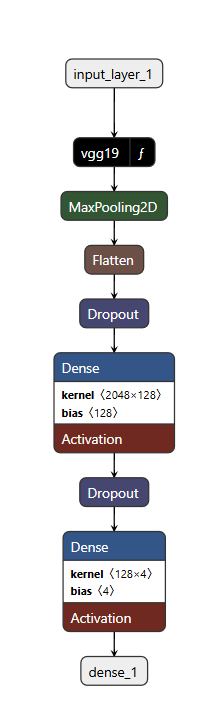

In [64]:

from IPython.display import Image

# Display the image
Image(filename=img[0])
